In [60]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize 
from operator import itemgetter

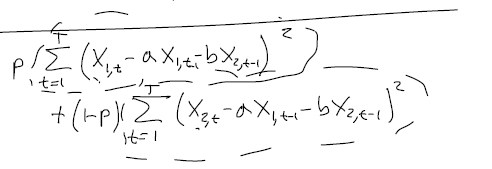

$$C = \frac{1}{T-1}\sum_{t = 2}^T \left(p \left(X_t - (aX_{t - 1} - b Y_{t-1})\right)^2 + (1 - p)\left(Y_t - (aX_{t-1} + bY_{t-1})\right)^2\right)$$

## Generate a Doubly Stochastic Matrix

In [61]:
def generate_data_nD(length, n, A):
    
    # Initialize series
    series = np.array(np.zeros((length, n)))
    
    # Precalculate inverse
    inv_P = np.linalg.inv(P)
    
    # Generate series
    for t in range(1, length):
        # Generate VAR model
        series[t] = np.matmul(inv_P, np.matmul(A, np.matmul(P, series[t - 1])) + np.random.multivariate_normal(np.zeros(n), np.identity(n)))
    
    return series

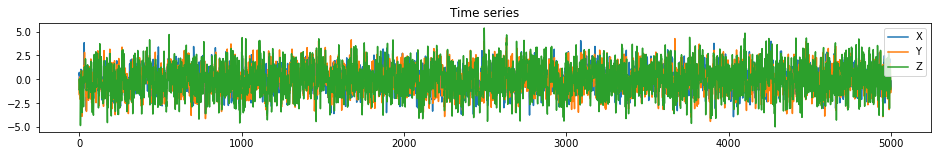

Actual A:
 [[0.4359949  0.         0.        ]
 [0.43532239 0.4203678  0.        ]
 [0.20464863 0.61927097 0.29965467]]

Actual P:
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [65]:
np.random.seed(seed = 2)

length, n = 5000, 3

# A matrix, lower triangular
A = np.tril(np.random.rand(n, n))
# A = np.array([[0.0, 0.0, 0.0], [0.8, 0.0, 0.0], [0.8, 0.8, 0.0]])

# Permutation
P = np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]])

# Generate nD data
series = generate_data_nD(length, n, A)

# Plot
plt.figure(figsize=(16,2))
plt.title("Time series")
plots = plt.plot(series)
plt.legend(plots, ["X", "Y", "Z"], loc=1)
plt.show()

print("Actual A:\n", A)

print("\nActual P:\n", P)

In [4]:
def C_n(variables):
    p11, p12, p21, p22 = variables[:4]
    P = np.array([[p11, p12, 1- p11 - p12], [p21, p22, 1- p21 - p22], [1 - p11 - p21, 1 - p12 - p22, 1 - (1 - p11 - p21) - (1 - p12 - p22)]])

    a11, a21, a22, a31, a32, a33 = variables[4:]
    A = np.array([[a11, 0.0, 0.0], [a21, a22, 0.0], [a31, a32, a33]])
    cost = 0

    P_inv = np.linalg.inv(P) # P.transpose() / np.linalg.det(P)
    B = np.matmul(P_inv, np.matmul(A, P))
    
    for t in range(1, length):
        val = series[t]
        est = np.matmul(B, series[t - 1])
        cost += np.linalg.norm(val - est, ord = 2) ** 2

    return cost / (length - 1) # + 0.1 * np.sum(np.abs(B)) # regularization

In [5]:
def p_list_to_p_matrix(ps):
    P_matrix = np.zeros((n, n))
    P_matrix[:n-1,:n-1] = ps.reshape((n - 1, n - 1))
    P_matrix[:n-1, n - 1] = 1 - P_matrix[:n-1,:].sum(axis = 1)
    P_matrix[n - 1, :] = 1 - P_matrix.sum(axis = 0)
    return P_matrix

ps = np.array([0.2, 0.5, 0.1, 0.2])
print(p_list_to_p_matrix(ps))

[[0.2 0.5 0.3]
 [0.1 0.2 0.7]
 [0.7 0.3 0. ]]


In [6]:
from scipy import optimize

def closest_perm_1(P_DS):
    # convert to get the maximum linear assignment problem
    P_MOD = np.ones((n, n)) * np.max(P_DS) - P_DS
    row_ind, col_ind = optimize.linear_sum_assignment(P_MOD)

    # Create Permutation matrix to return
    P_perm = np.zeros((n, n))

    for row, col in zip(row_ind, col_ind):
        P_perm[row][col] = 1 
    
    return P_perm

In [66]:
# three dimensional constraints
a = np.identity(10)[:4,]                                      # 0 <= p <= 1 for all p
a1 = np.append(np.array([1.0, 1.0, 0.0, 0.0]), np.zeros(6))   # 0 <= sum(row(1)) <= 1
a2 = np.append(np.array([0.0, 0.0, 1.0, 1.0]), np.zeros(6))   # 0 <= sum(row(2)) <= 1
a3 = np.append(np.array([1.0, 0.0, 1.0, 0.0]), np.zeros(6))   # 0 <= sum(col(1)) <= 1
a4 = np.append(np.array([0.0, 1.0, 0.0, 1.0]), np.zeros(6))   # 0 <= sum(col(2)) <= 1
a5 = np.append(np.array([1.0, 1.0, 1.0, 1.0]), np.zeros(6))   # 0 <= sum(col(3)) <= 1

outcome = []

# set constraints
V = np.vstack((a, a1, a2, a3, a4, a5))
L = [0, 0, 0, 0, 0, 0, 0, 0, 1]
U = [1, 1, 1, 1, 1, 1, 1, 1, 2]

np.random.seed(seed = 1)

for _ in range(1):
    # minimize, starting from a random entry
    results = optimize.minimize(C_n, np.random.rand(10), constraints = optimize.LinearConstraint(V, L, U)).x

    # get results
    P_DS_out = p_list_to_p_matrix(results[:4])
    P_perm_out = closest_perm_1(np.round(p_list_to_p_matrix(results[:4]), 2))
    
    A_out = np.array([[results[4], 0, 0], [results[5], results[6], 0], [results[7], results[8], results[9]]])
    
    print(np.round(P_DS_out, 2))
    print("B:\n", np.round(np.matmul(np.linalg.inv(P_DS_out), np.matmul(A_out, P_DS_out)), 3))
    print("B*:\n", np.matmul(np.linalg.inv(P), np.matmul(A, P)))
    print(A_out, P_DS_out)
    
    outcome.append([P_perm_out, np.linalg.norm(P_DS_out - P_perm_out, ord='fro')])
    print(C_n(results))
    
    # print(P_perm_out)
    # print(round(np.linalg.norm(P_DS_out - P_perm_out, ord='fro'), 3))

outcome = sorted(outcome, key=itemgetter(1))

for elem in outcome:
    print("P:", elem[0])
    print("Cost:\n", elem[1])

[[0.98 0.02 0.  ]
 [0.02 0.98 0.  ]
 [0.   0.   1.  ]]
B:
 [[0.437 0.    0.   ]
 [0.437 0.421 0.   ]
 [0.191 0.624 0.305]]
B*:
 [[0.4359949  0.         0.        ]
 [0.43532239 0.4203678  0.        ]
 [0.20464863 0.61927097 0.29965467]]
[[0.4449024  0.         0.        ]
 [0.4375627  0.41368739 0.        ]
 [0.18287363 0.63145731 0.30520751]] [[0.98263569 0.01736431 0.        ]
 [0.01736431 0.98263569 0.        ]
 [0.         0.         1.        ]]
2.9977600795611683
P: [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Cost:
 0.03472862518086893


In [8]:
def C_n_2(variables):
    P, A = variables
    cost = 0

    P_inv = np.linalg.inv(P) # P.transpose() / np.linalg.det(P)
    B = np.matmul(P_inv, np.matmul(A, P))
    
    for t in range(1, length):
        val = series[t]
        est = np.matmul(B, series[t - 1])
        cost += np.linalg.norm(val - est) ** 2

    return cost / (length - 1) # + 0.1 * np.sum(np.abs(B)) # regularization

In [9]:
def C_n_v4(variables):
    p11, p12, p21, p22 = variables[:4]
    P = np.array([[p11, p12, 1- p11 - p12], [p21, p22, 1- p21 - p22], [1 - p11 - p21, 1 - p12 - p22, 1 - (1 - p11 - p21) - (1 - p12 - p22)]])

    a11, a21, a22, a31, a32, a33 = variables[4:]
    A = np.array([[a11, 0.0, 0.0], [a21, a22, 0.0], [a31, a32, a33]])
    cost = 0

    P_trans = P.transpose()
    for t in range(1, length):
        val = series[t]
        est = np.matmul(P_trans, np.matmul(A, np.matmul(P, series[t - 1])))
        cost += np.linalg.norm(val - est) ** 2

    return cost / (length - 1) # + np.abs(A)

## Find "Closest" permutation matrix
Using the Hungarian Algorithm, we can find the "closest" permutation matrix $P_{perm}$ to $P_{DS}$.

In [10]:
def gen_P(n):
    P = np.random.random((n, n))
    rsum, csum = 0, 0

    # Sinkhorn balancing from a random matrix
    while (np.any(np.round(rsum, 3) != 1)) | (np.any(np.round(csum, 3) != 1)):
        P /= P.sum(0)
        P = P / P.sum(1)[:, np.newaxis]
        rsum = P.sum(1)
        csum = P.sum(0)
        
    return P

In [11]:
def closest_perm_2(P_DS):
    P_2 = P_DS.copy()
    # for each row
    for _ in range(n):
        # Normalize each row by dividing by its smallest non-zero entry
        for j in range(n):
            P_2[:, j] /= np.min(P_2[:, j][np.nonzero(P_2[:, j])])

        # get largest entry in P
        i, j = np.unravel_index(np.argmax(P_2, axis=None), P_2.shape)

        # set all other values in that row and column to zero
        for i1 in range(n):
            P_2[i][i1] = 0
            P_2[i1][j] = 0

        # set the largest entry in P to 1
        P_2[i][j] = 1

    return P_2

In [12]:
def closest_perm_3(P_DS):
    P_2 = P_DS.copy()
    # for each row
    for _ in range(n):
        # Normalize each row by dividing by its smallest non-zero entry
        for i in range(n):
            P_2[i] /= np.min(P_2[i][np.nonzero(P_2[i])])


        # get largest entry in P
        i, j = np.unravel_index(np.argmax(P_2, axis=None), P_2.shape)

        # set all other values in that row and column to zero
        for i1 in range(n):
            P_2[i][i1] = 0
            P_2[i1][j] = 0

        # set the largest entry in P to 1
        P_2[i][j] = 1

    return P_2

In [13]:
def closest_perm_4(P_DS):
    P_2 = P_DS.copy() * -1
    # for each row
    for _ in range(n):
        # get largest entry in P
        i, j = np.unravel_index(np.argmin(P_2, axis=None), P_2.shape)
    
        # set all other values in that row and column to zero
        for i1 in range(n):
            P_2[i][i1] = 0
            P_2[i1][j] = 0
        
        # set the largest entry in P to 1
        P_2[i][j] = 1

    return P_2

In [14]:
P_DS = gen_P(n)
print(P_DS)
print(closest_perm_1(P_DS), end = "\n\n")
print(closest_perm_2(P_DS), end = "\n\n")
print(closest_perm_3(P_DS), end = "\n\n")
print(closest_perm_4(P_DS), end = "\n\n")

[[4.02526650e-01 5.97211286e-01 2.62064145e-04]
 [4.66865565e-01 1.94655466e-01 3.38478969e-01]
 [1.30716438e-01 2.08304499e-01 6.60979062e-01]]
[[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]

[[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]

[[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]

[[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]



[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] [[0.4359949  0.         0.        ]
 [0.43532239 0.4203678  0.        ]
 [0.20464863 0.61927097 0.29965467]]
1 2, ...,  2 1, ...,  

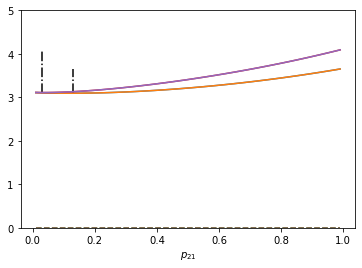

In [15]:
def verify_gradient_p(i, j, P = P, A = A):
    print(f"{i} {j}, ..., ", end = " ")
    x_lim_1, x_lim_2 = 0.01, 0.99
    p_list = np.linspace(x_lim_1, x_lim_2, 50)
    results = [[], []]

    for p in p_list:
        old_p = P[i - 1][j - 1]
        
        P[i - 1][n - 1] += (P[i - 1][j - 1] - p)
        P[n - 1][j - 1] += (P[i - 1][j - 1] - p)
        P[n - 1][n - 1] -= (P[i - 1][j - 1] - p)
        P[i - 1][j - 1] = p
        results[0].append(C_n_2([P, A]))
        results[1].append(C_n_2([P, A]))

        P[i - 1][n - 1] += (P[i - 1][j - 1] - old_p)
        P[n - 1][j - 1] += (P[i - 1][j - 1] - old_p)
        P[n - 1][n - 1] -= (P[i - 1][j - 1] - old_p)
        P[i - 1][j - 1] = old_p

    plt.xlabel(f"$p_{{{str(i) + str(j)}}}$")
    plt.ylim(0, 5)
    if i == 1 and j == 1:
        plt.plot(p_list, results[0], label = r"$C(p_{ij})$")
        plt.plot(p_list, results[1], label = r"$\frac{\partial C(p_{ij})}{\partial p_{ij}}$")
        plt.plot([x_lim_1, x_lim_2], [0, 0], linestyle = '--', label = r"$y = 0$")
        plt.vlines(p_list[np.where(results[0] == np.amin(results[0]))], np.min(results), np.max(results), linestyle = 'dashdot', label = r"$x = \arg \min\ C(p_{ij})$", color = 'black')
        # plt.vlines(P[i - 1][j - 1], np.min(results), np.max(results), linestyle = '--', label = r"$x = \hat{p}_{ij}$")
    else:
        plt.plot(p_list, results[0])
        plt.plot(p_list, results[1])
        plt.plot([x_lim_1, x_lim_2], [0, 0], linestyle = '--')
        plt.vlines(p_list[np.where(results[0] == np.amin(results[0]))], np.min(results), np.max(results), linestyle = 'dashdot', color = 'black')
        # plt.vlines(P[i - 1][j - 1], np.min(results), np.max(results), linestyle = '--')

print(P, A)
# verify_gradient_p(1, 1, P, A)
verify_gradient_p(1, 2, P, A)
verify_gradient_p(2, 1, P, A)
# verify_gradient_p(2, 2, P, A)

$$C(A, P, A^*, P^*) = \left\lVert P^{*-1}A^*P^*X_{t-1} + \Sigma- P^{-1}APX_{t-1}\right\rVert_2^2,$$

# Gradient w.r.t. $A$
What is $$\frac{\partial C(A, P, A^*, P^*)}{\partial A}?$$

\begin{align*}
\frac{\partial C(A, P, A^*, P^*)}{\partial a_{ij}} &= \frac{\partial}{\partial a_{ij}} \frac{1}{T - 1} \sum_{t = 2}^T \sum_{k = 1}^n (X_{t,i} - (P^{-1}APX_{t-1})_i)^2 \\ 
&= \frac{1}{T - 1} \sum_{t = 2}^T \sum_{k = 1}^n 2 (X_{t,k} - (P^{-1}APX_{t-1})_k) \frac{\partial}{\partial a_{ij}}(X_{t,k} - (P^{-1}APX_{t-1})_k) \\
&= \frac{1}{T - 1} \sum_{t = 2}^T \sum_{k = 1}^n 2 (X_{t,k} - (P^{-1}APX_{t-1})_k) \cdot - (P^{-1}J_{ij}PX_{t-1})_k).
\end{align*}

Note: The cost function is quadratic w.r.t. the entries in $A$, and hence, linear w.r.t. the entries in $A$. Hence, optimizing with respect to $A$ is incredibly easy and can be done in just two derivative inspections, creating a line, and computing the value for which this linear function evaluates to zero.

In [16]:
def C_aij(variables, i = 1, j = 1):
    """Calculate the derivative of C w.r.t aij"""
    P, A  = variables
    # transform the P_DS to a P_perm for the actual value
    derivative = 0
    
    P_inv = np.linalg.inv(P)
    
    w_i = np.argmax(P[i - 1])
    
    for t in range(1, length):
        for k in range(n):
            val = series[t][k]
            est = np.matmul(P_inv, np.matmul(A, np.matmul(P, series[t - 1])))[k]
        
            J = np.zeros((n, n))
            J[i - 1][j - 1] = 1
        
            derivative += -2 * (val - est) * np.matmul(P_inv, np.matmul(J, np.matmul(P, series[t - 1])))[k]
        
    return derivative / (length - 1)

1 1, ...,  2 1, ...,  2 2, ...,  3 1, ...,  3 2, ...,  3 3, ...,  

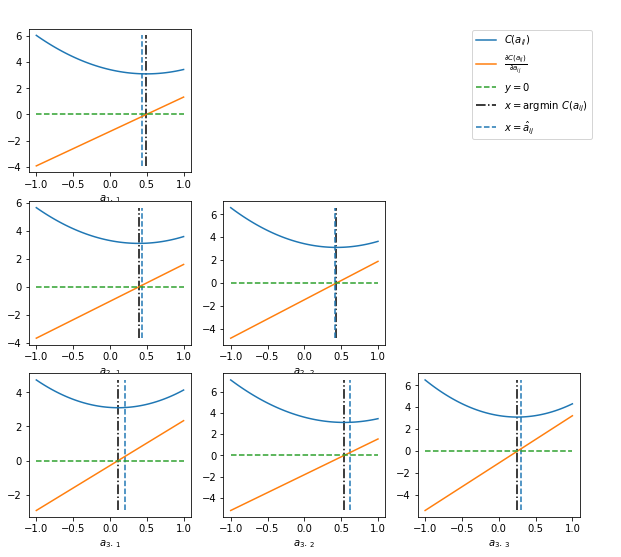

In [17]:
def verify_gradient_a(i, j, P = P, A = A):
    print(f"{i} {j}, ..., ", end = " ")
    a_list = np.linspace(-1.0, 1.0, 100)
    results = [[], []]

    a_temp = A[i - 1][j - 1]
    
    for a in a_list:
        A[i - 1][j - 1] = a

        results[0].append(C_n_2([P, A]))
        results[1].append(C_aij([P, A], i = i, j = j))
    A[i - 1][j - 1] = a_temp
        
    plt.xlabel(f"$a_{i}._{j}$")
    
    # plt.ylim(-0.1,0.1)
    if i == 1 and j == 1:
        plt.plot(a_list, results[0], label = r"$C(a_{ij})$")
        plt.plot(a_list, results[1], label = r"$\frac{\partial C(a_{ij})}{\partial a_{ij}}$")
        plt.plot([-1, 1], [0, 0], linestyle = '--', label = r"$y = 0$")
        plt.vlines(a_list[np.where(results[0] == np.amin(results[0]))], np.min(results), np.max(results), linestyle = 'dashdot', label = r"$x = \arg \min\ C(a_{ij})$", color = 'black')
        plt.vlines(A[i - 1][j - 1], np.min(results), np.max(results), linestyle = '--', label = r"$x = \hat{a}_{ij}$")
    else:
        plt.plot(a_list, results[0])
        plt.plot(a_list, results[1])
        plt.plot([-1, 1], [0, 0], linestyle = '--')
        plt.vlines(a_list[np.where(results[0] == np.amin(results[0]))], np.min(results), np.max(results), linestyle = 'dashdot', color = 'black')
        plt.vlines(A[i - 1][j - 1], np.min(results), np.max(results), linestyle = '--')
        

# Create a Position index
plt.figure(figsize = (3 * n, 3 * (n - 1)))
plt.subplots_adjust(bottom = -0.25, left = 0.05)

position = range(1, n ** 2 + 1)

fig = plt.figure(1)

for k in range(n ** 2):
    # add every single subplot to the figure with a for loop    
    if k // n >= k % n:
        ax = fig.add_subplot(n, n, position[k])
        verify_gradient_a(k // n + 1, k % n + 1)

fig.legend(loc = 'upper right', ncol = 1, borderaxespad = 3.0)
plt.show()

# Gradient w.r.t. $P$
What is $$\frac{\partial C(A, P, A^*, P^*)}{\partial P}?$$

This will be much trickier. We have that 
$$\frac{\partial P^{-1}}{\partial p_{ij}} = - P^{-1} \frac{\partial P}{\partial p_{ij}} P^{-1}.$$

Hence, 

\begin{align*}
\frac{\partial C(A, P, A^*, P^*)}{\partial p_{ij}} &= \frac{\partial}{\partial p_{ij}} \frac{1}{T - 1} \sum_{t = 2}^T \sum_{k = 1}^n (X_{t,i} - (P^{-1}APX_{t-1})_i)^2 \\ 
&= \frac{1}{T - 1} \sum_{t = 2}^T \sum_{k = 1}^n 2 (X_{t,k} - (P^{-1}APX_{t-1})_k) \frac{\partial}{\partial p_{ij}}(X_{t,k} - (P^{-1}APX_{t-1})_k) \\
&= \frac{1}{T - 1} \sum_{t = 2}^T \sum_{k = 1}^n 2 (X_{t,k} - (P^{-1}APX_{t-1})_k) \cdot - \frac{\partial}{\partial p_{ij}}(P^{-1}APX_{t-1})_k).
\end{align*}

So, we need to find 

$$\frac{\partial}{\partial p_{ij}}(P^{-1}APX_{t-1})_k).$$

By using the product rule for matrix differentation, we get

$$\frac{\partial}{\partial p_{ij}}(P^{-1}APX_{t-1})_k) = \left(\left[\frac{\partial}{\partial p_{ij}}P^{-1}\right]APX_{t-1})\right)_k + \left(P^{-1}A\left[\frac{\partial}{\partial p_{ij}}P\right]X_{t-1})\right)_k.$$

Now, $$\left(P^{-1}A\left[\frac{\partial}{\partial p_{ij}}P\right]X_{t-1})\right)_k = \left(P^{-1}A\tilde{J}_{ij}X_{t-1})\right)_k,$$

where $$\tilde{J}_{ij} = J_{ij} - J_{in} - J_{nj} + J_{nn},\qquad\text{$i, j = 1, ..., n - 1$.}$$

Furthermore, 

\begin{align*}\left(\left[\frac{\partial}{\partial p_{ij}}P^{-1}\right]APX_{t-1})\right)_k &= \left(- P^{-1} \left[\frac{\partial P}{\partial p_{ij}}\right] P^{-1} APX_{t-1})\right)_k \\ &=\left(- P^{-1} \tilde{J}_{ij} P^{-1} APX_{t-1})\right)_k.
\end{align*}

All in all, we get that 
$$\frac{\partial}{\partial p_{ij}}(P^{-1}APX_{t-1})_k) = \left(- P^{-1} \tilde{J}_{ij} P^{-1} APX_{t-1})\right)_k + \left(P^{-1}A\tilde{J}_{ij}X_{t-1})\right)_k.$$

\begin{align*}
\frac{\partial C(A, P, A^*, P^*)}{\partial p_{ij}} &= \frac{1}{T - 1} \sum_{t = 2}^T \sum_{k = 1}^n 2 (X_{t,k} - (P^{-1}APX_{t-1})_k) \cdot - \left[\left(- P^{-1} \tilde{J}_{ij} P^{-1} APX_{t-1})\right)_k + \left(P^{-1}A\tilde{J}_{ij}X_{t-1})\right)_k\right]
\end{align*}

In [18]:
def C_pij(variables, i = 1, j = 1):
    """Calculate the derivative of C w.r.t aij"""
    P, A  = variables
    # transform the P_DS to a P_perm for the actual value
    derivative = 0
    
    P_inv = np.linalg.inv(P)
    
    for t in range(1, length):
        for k in range(n):
            val = series[t][k]
            est = np.matmul(P_inv, np.matmul(A, np.matmul(P, series[t - 1])))[k]
        
            J_tilde = np.zeros((n, n))
            J_tilde[i - 1][j - 1] = 1
            J_tilde[i - 1][n - 1] = -1
            J_tilde[n - 1][j - 1] = -1
            J_tilde[n - 1][n - 1] = 1
            
            to_add = -np.matmul(P_inv, np.matmul(A, np.matmul(J_tilde, series[t - 1])))[k]
            to_add += np.matmul(P_inv, np.matmul(J_tilde, np.matmul(P_inv, np.matmul(A, np.matmul(P, series[t - 1])))))[k]
            
            derivative += 2 * (val - est) * to_add
        
    return derivative / (length - 1)

In [46]:
def verify_gradient_p(i, j, P = P, A = A):
    print(f"{i} {j}, ..., ", end = " ")
    x_lim_1, x_lim_2 = -0.1, 0.999
    p_list = np.linspace(x_lim_1, x_lim_2, 43)
    results = [[], []]

    for p in p_list:
        old_p = P[i - 1][j - 1]
        
        P[i - 1][n - 1] += (P[i - 1][j - 1] - p)
        P[n - 1][j - 1] += (P[i - 1][j - 1] - p)
        P[n - 1][n - 1] -= (P[i - 1][j - 1] - p)
        P[i - 1][j - 1] = p
        
        results[0].append(C_n_2([P, A]))
        results[1].append(C_pij([P, A], i = i, j = j))

        P[i - 1][n - 1] += (P[i - 1][j - 1] - old_p)
        P[n - 1][j - 1] += (P[i - 1][j - 1] - old_p)
        P[n - 1][n - 1] -= (P[i - 1][j - 1] - old_p)
        P[i - 1][j - 1] = old_p

    plt.xlabel(f"$p_{{{str(i) + str(j)}}}$")
    plt.ylim(-10, 10)
    if i == 1 and j == 1:
        plt.plot(p_list, results[0], label = r"$C(p_{ij})$")
        plt.plot(p_list, results[1], label = r"$\frac{\partial C(p_{ij})}{\partial p_{ij}}$")
        plt.plot([x_lim_1, x_lim_2], [0, 0], linestyle = '--', label = r"$y = 0$")
        plt.vlines(p_list[np.where(results[0] == np.amin(results[0]))], np.min(results), np.max(results), linestyle = 'dashdot', label = r"$x = \arg \min\ C(p_{ij})$", color = 'black')
        # plt.vlines(P[i - 1][j - 1], np.min(results), np.max(results), linestyle = '--', label = r"$x = \hat{p}_{ij}$")
    else:
        plt.plot(p_list, results[0])
        plt.plot(p_list, results[1])
        plt.plot([x_lim_1, x_lim_2], [0, 0], linestyle = '--')
        plt.vlines(p_list[np.where(results[0] == np.amin(results[0]))], np.min(results), np.max(results), linestyle = 'dashdot', color = 'black')
        # plt.vlines(P[i - 1][j - 1], np.min(results), np.max(results), linestyle = '--')

1 2, ...,  

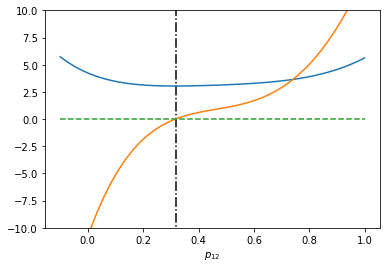

In [52]:
A2 = np.array([[0.69438959, 0., 0.], [0.49239661, 0.27795366, 0.], [-0.32674082, 1.06375749, 0.21882803]]) 
P2 = np.array([[0.60936718, 0.37763597, 0.01299686], [0.32007374, 0.61413819, 0.06578808], [0.07055909, 0.00822584, 0.92121507]])

verify_gradient_p(1, 2, P2, A2)

In [50]:
print("B:\n", np.round(np.matmul(np.linalg.inv(P2), np.matmul(A2, P2)), 3))
print("B*:\n", np.matmul(np.linalg.inv(P), np.matmul(A, P)))

B:
 [[0.455 0.141 0.004]
 [0.382 0.447 0.007]
 [0.132 0.562 0.29 ]]
B*:
 [[0.4359949  0.         0.        ]
 [0.43532239 0.4203678  0.        ]
 [0.20464863 0.61927097 0.29965467]]


In [43]:
# C_n_2([P2, A2])
C_n_2([P, A])

3.1125752260903834